<font size = 25> Alice Spring Hydrograph Analysis</font>

# Imports

In [14]:
% matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import rasterio
import xarray as xr
from shapely.geometry import Point

# Load Data

## SWL Timeseries

In [15]:
# open up CSV of SWL depths for all NT bores
data = pd.read_csv(r'\\prod.lan\active\proj\futurex\StuartCorridor\Data\Original\BoreHoles\Water\gdb_NT\level_NT.csv')
# drop unneeded columns
data = data.drop(labels=['hydroid'], axis =1)
# format datetime field to datetime from string
data['bore_date'] = data['bore_date'].astype(np.datetime64)
data.head()

C:\Users\u19955\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag
0,RN000438,w00067,2016-03-07 00:00:00,SWL,19.59,quality-A
1,RN000438,w00067,2016-08-22 00:00:00,SWL,19.59,quality-A
2,RN000438,w00067,2017-03-20 00:00:00,SWL,19.60,quality-A
3,RN001476,w00067,2011-08-10 15:15:00,SWL,12.58,quality-A
4,RN001476,w00067,2011-08-10 15:15:00,SWL,12.58,quality-A


## Load Borehole Header Data

In [16]:
# open up the borehole header data file for all NT bores
bh_header = gpd.read_file(r'\\prod.lan\active\proj\futurex\StuartCorridor\Working\Mike\Boreholes\NT_Bores_DEM4.shp')
# rename the existing elevation field
bh_header = bh_header.rename({'RASTERVALU':'SRTM-1sec'}, axis = 1)
# flag nulls as NaN
bh_header.loc[bh_header[bh_header['SRTM-1sec'] == -9999.00000].index,'SRTM-1sec'] = np.nan
bh_header.head()

,UFI,BORE_NO,BORE_NAME,BOREREPORT,WATER_DATA,STATUS,PURPOSE,YIELD,YIELDCLASS,COMPL_DATE,...,LATITUDE,LONGITUDE,GRDATUM,ZONE,EASTING,NORTHING,MAP_INDEX,MONITORED,SRTM-1sec,geometry
0,1,RN000001,REPL. GILLENS BORE=YAMBAH,http://www.ntlis.nt.gov.au/hpa-services/borere...,None,NOT IN USE,farming,0.4,0.0 - 1.0 L/s,1956-04-17,...,-23.085224,133.67676,MGA94,53.0,364468.8,7446432.2,16.0,None,682.727356,POINT (133.6767558384341 -23.08522396162067)
1,2,RN000002,ALICE WELL BORE N.S.S.R. 30KM (SSE) OF HOMESTEAD.,http://www.ntlis.nt.gov.au/hpa-services/borere...,None,NOT IN USE,farming,2.5,2.0 - 5.0 L/s,1956-09-21,...,-24.892428,134.22899,MGA94,53.0,422128.8,7246742.9,9.0,None,NaN,POINT (134.228993234647 -24.89242825326743)
2,3,RN000003,FRANCIS WELL BORE No2. 1.3KM (S) OF H/STEAD OP...,http://www.ntlis.nt.gov.au/hpa-services/borere...,None,NOT IN USE,farming,1.2,1.0 - 2.0 L/s,1956-09-18,...,-24.682155,134.07247,MGA94,53.0,406160.8,7269928.8,9.0,None,NaN,POINT (134.0724662182159 -24.68215536462449)
3,4,RN000004,ALUMBARA 2ND ATT. [ABD] 7M (E) OF RN11172.,http://www.ntlis.nt.gov.au/hpa-services/borere...,None,NOT IN USE,farming,3.8,2.0 - 5.0 L/s,1956-03-27,...,-23.170349,131.62310,MGA94,52.0,768545.8,7435202.6,14.0,None,589.039185,POINT (131.6230981459488 -23.17034877716835)
4,5,RN000005,ALLUMBUARA NO TRACE 10/5/93 32KM (W) OF PAPUNYA.,http://www.ntlis.nt.gov.au/hpa-services/borere...,None,None,farming,0.1,0.0 - 1.0 L/s,1956-01-01,...,-23.185148,131.62228,MGA94,52.0,768432.8,7433564.6,14.0,None,592.102966,POINT (131.6222834583905 -23.18514804115302)


## Load SRTM Elevation Data

In [17]:
# open the SRTM raster for the SSC
elev = xr.open_rasterio(r'\\prod.lan\active\proj\futurex\StuartCorridor\Data\Original\ElevationDepth\Elevation\SSC_SRTM-DEM_v1-0\GA_1secSRTM_DEM_v1.0.tif')
elev

<xarray.DataArray (band: 1, y: 22228, x: 24512)>
[544852736 values with dtype=float32]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 -18.31 -18.31 -18.31 -18.31 -18.31 -18.31 -18.31 ...
  * x        (x) float64 130.5 130.5 130.5 130.5 130.5 130.5 130.5 130.5 ...
Attributes:
    crs:      +init=epsg:4326

## Add Elevations to NT Boreholes that don't have them

In [21]:
def getElev(row):
    lat = row['LATITUDE']
    lon = row["LONGITUDE"]
    return elev.sel(x = lon, y = lat, method = 'nearest').values

# for rows with no elevation data, find the value of the SRTM pixel that the bore falls on
bh_header.loc[bh_header['SRTM-1sec'].isna(),'SRTM-1sec'] = bh_header[bh_header['SRTM-1sec'].isna()].apply(getElev, axis = 1)
# free up some memory (file is > 1GB)
del elev
bh_header.head()

NameError: name 'elev' is not defined

## Load Alice Springs Study Area

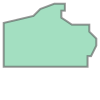

In [22]:
# open the EFTF study area polygons
eftf_areas = gpd.read_file(r'\\prod.lan\active\proj\futurex\StuartCorridor\Data\Processed\Boundaries\Extents\EFTF_extentsMarch2107\EFTF_extents_March_2017.shp')
# chose the Alice Springs area
as_shp = eftf_areas[eftf_areas['Name'] == 'Alice Springs']['geometry'].values[0]
as_shp

In [23]:
# merge the hydrograph data with the X,Y,Z data from the bh_headers dataframe
data = pd.merge(data, bh_header[['BORE_NO','SRTM-1sec','LATITUDE','LONGITUDE','geometry']], how = 'left', left_on ='bore_id', right_on = 'BORE_NO')
# calculate depth to watertable in AHD
data['WaterTableAHD'] = data['SRTM-1sec'] - data['result']
# determine if the bore is in the AS study area
data['in_AS'] = [True if data.iloc[i,data.columns.get_loc('geometry')].intersects(as_shp) else False for i in range(len(data))]
data.head()

,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag,BORE_NO,SRTM-1sec,LATITUDE,LONGITUDE,geometry,WaterTableAHD,in_AS
0,RN000438,w00067,2016-03-07,SWL,19.59,quality-A,RN000438,393.795,-21.008859,134.18892,POINT (134.1889172357893 -21.00885913413194),374.205,False
1,RN000438,w00067,2016-03-07,SWL,19.59,quality-A,RN000438,393.795,-21.008859,134.18892,POINT (134.1889172357893 -21.00885913413194),374.205,False
2,RN000438,w00067,2016-08-22,SWL,19.59,quality-A,RN000438,393.795,-21.008859,134.18892,POINT (134.1889172357893 -21.00885913413194),374.205,False
3,RN000438,w00067,2016-08-22,SWL,19.59,quality-A,RN000438,393.795,-21.008859,134.18892,POINT (134.1889172357893 -21.00885913413194),374.205,False
4,RN000438,w00067,2017-03-20,SWL,19.60,quality-A,RN000438,393.795,-21.008859,134.18892,POINT (134.1889172357893 -21.00885913413194),374.195,False


In [24]:
# subset the data to the AS only bores
as_data = data[data['in_AS']]
as_data.head()

,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag,BORE_NO,SRTM-1sec,LATITUDE,LONGITUDE,geometry,WaterTableAHD,in_AS
20346,RN002643,w00067,2010-03-15 11:12:00,SWL,2.27,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.463,True
20347,RN002643,w00067,2010-03-15 11:12:00,SWL,2.27,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.463,True
20348,RN002643,w00067,2010-03-16 19:30:00,SWL,2.32,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.413,True
20349,RN002643,w00067,2010-03-16 19:30:00,SWL,2.32,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.413,True
20350,RN002643,w00067,2010-03-17 19:00:00,SWL,2.28,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.453,True


In [26]:
as_ap_rain = pd.read_csv('../KeyData/IDCJAC0009_015590_1800_Data.csv')
as_ap_rain = as_ap_rain[as_ap_rain['Year'] >= 1980]
as_ap_rain.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
14244,IDCJAC0009,15590,1980,1,1,0.6,1.0,Y
14245,IDCJAC0009,15590,1980,1,2,0.0,NaN,Y
14246,IDCJAC0009,15590,1980,1,3,0.4,1.0,Y
14247,IDCJAC0009,15590,1980,1,4,4.8,1.0,Y
14248,IDCJAC0009,15590,1980,1,5,0.2,1.0,Y


In [30]:
def makeDates(row):
    
    def addLeadingZero(n):
        if isinstance(n, int) and n > 0 and n < 10:
            return '0'+ str(n)
        else:
            return str(n)
        
    return np.datetime64(str(row['Year']) + '-' + addLeadingZero(row['Month']) + '-' + addLeadingZero(row['Day']))

as_ap_rain['date'] = as_ap_rain.apply(makeDates, axis = 1)
as_ap_rain = as_ap_rain.set_index('date', drop = False)
as_ap_rain.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality,date
date,,,,,,,,,
1980-01-01,IDCJAC0009,15590,1980,1,1,0.6,1.0,Y,1980-01-01
1980-01-02,IDCJAC0009,15590,1980,1,2,0.0,NaN,Y,1980-01-02
1980-01-03,IDCJAC0009,15590,1980,1,3,0.4,1.0,Y,1980-01-03
1980-01-04,IDCJAC0009,15590,1980,1,4,4.8,1.0,Y,1980-01-04
1980-01-05,IDCJAC0009,15590,1980,1,5,0.2,1.0,Y,1980-01-05


In [59]:
# figure out how many readings each bore has
readingscount = as_data.groupby('bore_id').count()
# pick the top 5 bores for further investigation
best_bores = readingscount.sort_values(by=['bore_date'], ascending=False).head(10).index
best_bores

Index(['RN011154', 'RN011381', 'RN004484', 'RN004688', 'RN011320', 'RN017939',
       'RN017438', 'RN017234', 'RN010720', 'RN017244'],
      dtype='object', name='bore_id')

In [46]:
rain_resamp = as_ap_rain.resample('W').sum()

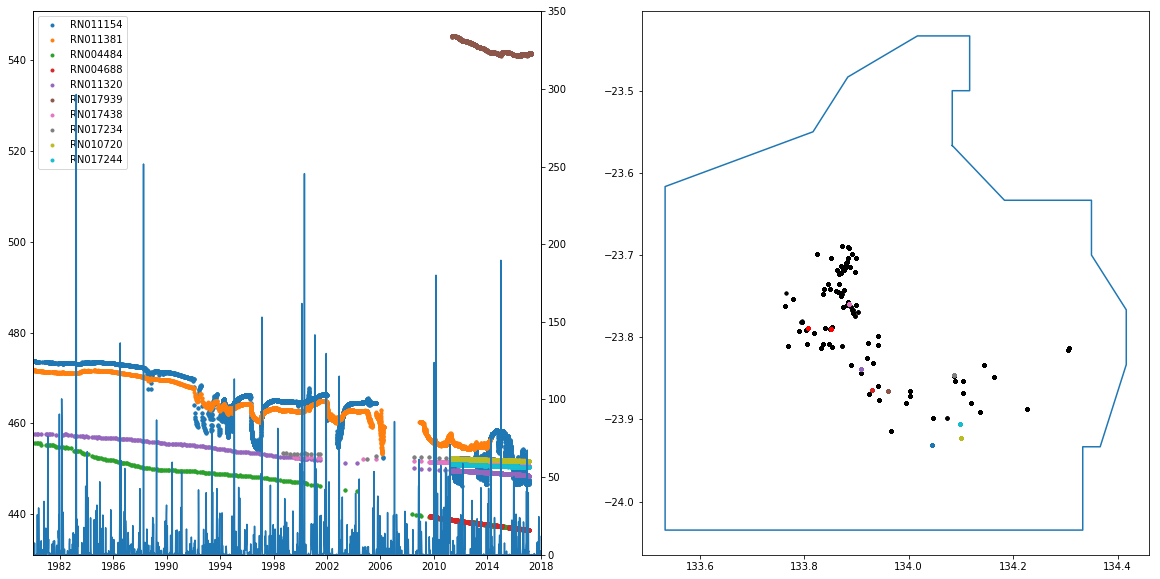

In [66]:
# plot up the timeseries for viewing
plt.figure(figsize = [20,10])
plt.subplot(1,2,1)
ax1 = plt.gca()
for bore in best_bores:
    ss = as_data[as_data['bore_id'] == bore]
    ax1.plot(ss['bore_date'],ss['WaterTableAHD'],'.', label=bore)
ax1.set_ylim = ([430,480])
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(rain_resamp.index, rain_resamp['Rainfall amount (millimetres)'])
ax2.set_ylim([0,350])
ax2.set_xlim(['1980','2018'])



plt.subplot(1,2,2)
x, y = as_shp.exterior.coords.xy
plt.plot(x, y)
plt.plot(as_data['LONGITUDE'],as_data['LATITUDE'], 'k.', label = None)

BOI = ['RN011154', 'RN011381']
for bore in range(len(best_bores)):
    plt.plot(as_data[as_data['bore_id'] == best_bores[bore]]['LONGITUDE'], as_data[as_data['bore_id'] == best_bores[bore]]['LATITUDE'], '.', label = as_data[as_data['bore_id'] == best_bores[bore]]['bore_id'])
# plt.plot(as_data[as_data['bore_id'].isin(best_bores)]['LONGITUDE'],as_data[as_data['bore_id'].isin(best_bores)]['LATITUDE'], '.')
plt.plot(as_data[as_data['bore_id'].isin(BOI)]['LONGITUDE'],as_data[as_data['bore_id'].isin(BOI)]['LATITUDE'], 'r.')
# plt.legend()
plt.show()


,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag,BORE_NO,SRTM-1sec,LATITUDE,LONGITUDE,geometry,WaterTableAHD,in_AS
20346,RN002643,w00067,2010-03-15 11:12:00,SWL,2.270,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.463,True
20347,RN002643,w00067,2010-03-15 11:12:00,SWL,2.270,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.463,True
20348,RN002643,w00067,2010-03-16 19:30:00,SWL,2.320,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.413,True
20349,RN002643,w00067,2010-03-16 19:30:00,SWL,2.320,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.413,True
20350,RN002643,w00067,2010-03-17 19:00:00,SWL,2.280,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.453,True
20351,RN002643,w00067,2010-03-17 19:00:00,SWL,2.280,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.453,True
20352,RN002643,w00067,2010-03-18 07:30:00,SWL,2.290,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.443,True
20353,RN002643,w00067,2010-03-18 07:30:00,SWL,2.290,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.443,True
20354,RN002643,w00067,2010-03-19 19:30:00,SWL,2.290,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.443,True
20355,RN002643,w00067,2010-03-19 19:30:00,SWL,2.290,quality-A,RN002643,581.733,-23.690126,133.88419,POINT (133.884192244441 -23.69012618646335),579.443,True
